In [1]:
#!/usr/bin/env python

# Generative Adversarial Networks (GAN) example in PyTorch. Tested with PyTorch 0.4.1, Python 3.6.7 (Nov 2018)
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9

from py_functions import fivenum

import sys
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

t = time.time()

matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False

# seeds
seed = 123
torch.manual_seed(seed)
np.random.seed(seed=seed)

# Data params
data_mean = 4
data_stddev = 1.25

# ### Uncomment only one of these to define what data is actually sent to the Discriminator
# (name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
# (name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
# (name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print("Using data [%s]" % (name))

# ##### DATA: Target data and generator input data


def get_distribution_sampler(mu, sigma):
    # Bell curve
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian


def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)   # Uniform-dist data into generator, _NOT_ Gaussian


# ##### MODELS: Generator model and discriminator model
class Generator(nn.Module):
    # Two hidden layers
    # Three linear maps
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x


class Discriminator(nn.Module):
    # also two hidden layer and three linear maps
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))


def extract(v):
    return v.data.storage().tolist()


def stats(d):
    return [np.mean(d), np.std(d)]


def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final


# def decorate_with_diffs(data, exponent, remove_raw_data=False):
#     mean = torch.mean(data.data, 1, keepdim=True)
#     mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
#     diffs = torch.pow(data - Variable(mean_broadcast), exponent)
#     if remove_raw_data:
#         return torch.cat([diffs], 1)
#     else:
#         return torch.cat([data, diffs], 1)


def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 1350
    print_interval = 100
    d_steps = 10
    g_steps = 10

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    # Activation functions
    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    # Now, training loop alternates between Generator and Discriminator modes

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real data
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
            d_real_error.backward()  # compute/store gradients, but don't change params

            #  1B: Train D on fake data
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("\t Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))
            sys.stdout.flush()

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        # print(" Values: %s" % (str(values)))
        # print(" fivemnum %s" % str(fivenum(values)))
        
        plt.hist(values, bins=50, alpha=0.6)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)

        # plt.show()
        # plt.savefig("fig.pdf")
        # time.sleep(0.1)
        # plt.savefig("fig.pdf")
        # plt.clf()
        plt.draw()
        # plt.show()
        # plt.show(block=False)
        plt.pause(0.1)
        
        # print("Seed: %d; epochs: %d" % (seed, epochs))
        

    return values


Using data [Only 4 moments]


Run:  0
	 Epoch 0: D (0.6278240084648132 real_err, 0.7675003409385681 fake_err) G (0.6247562170028687 err); Real Dist ([4.06202992349863, 1.2533160032819028]),  Fake Dist ([-0.09698092967271804, 0.04072233797370387]) 


/home/msfz751/anaconda3/envs/r-torch-jup/lib/python3.6/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


	 Epoch 100: D (0.6799901127815247 real_err, 0.6880636811256409 fake_err) G (0.6978486776351929 err); Real Dist ([4.041919274926186, 1.2134489407354332]),  Fake Dist ([-0.07967908541113138, 0.04207925442362191]) 
	 Epoch 200: D (0.5843085646629333 real_err, 0.5923900008201599 fake_err) G (0.8001345992088318 err); Real Dist ([4.003920792222023, 1.2362263918415264]),  Fake Dist ([0.3841201916337013, 0.05538094748317778]) 
	 Epoch 300: D (0.5718815922737122 real_err, 0.49410480260849 fake_err) G (0.9614760875701904 err); Real Dist ([4.043231249570846, 1.1933573060573708]),  Fake Dist ([4.563140733718872, 0.01781378383368324]) 
	 Epoch 400: D (0.6067327260971069 real_err, 0.8268445134162903 fake_err) G (0.54496830701828 err); Real Dist ([3.909938768684864, 1.2393620604879318]),  Fake Dist ([2.995265905857086, 1.1687877519010184]) 
	 Epoch 500: D (0.6814371943473816 real_err, 0.6658629179000854 fake_err) G (0.736302375793457 err); Real Dist ([3.9193006608188155, 1.187892911602872]),  Fake D

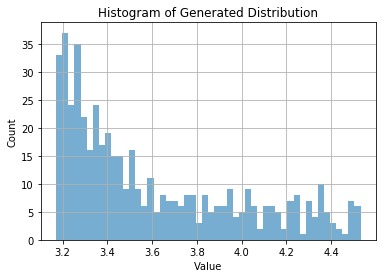

Seed: 123
[3.17094469, 3.27750134, 3.45596218, 3.89294767, 4.53159809]
Run:  1
	 Epoch 0: D (0.8564960956573486 real_err, 0.5257140398025513 fake_err) G (0.8915913105010986 err); Real Dist ([3.928095070362091, 1.188086981230475]),  Fake Dist ([-0.27438569396734236, 0.005031381714234374]) 
	 Epoch 100: D (0.5789336562156677 real_err, 0.5757827758789062 fake_err) G (0.8240000009536743 err); Real Dist ([3.912568745791912, 1.2149868925013343]),  Fake Dist ([0.7534522207975387, 0.0024970854074754067]) 
	 Epoch 200: D (0.6206120252609253 real_err, 0.5761755108833313 fake_err) G (0.8281481862068176 err); Real Dist ([4.0838424447178845, 1.259115178523643]),  Fake Dist ([5.393861915588379, 0.019447098390655823]) 
	 Epoch 300: D (0.17394812405109406 real_err, 0.21541939675807953 fake_err) G (1.6155470609664917 err); Real Dist ([4.050000485181808, 1.2228320090125424]),  Fake Dist ([5.519121215820313, 0.039863217743666475]) 
	 Epoch 400: D (0.2867792844772339 real_err, 0.32266759872436523 fake_err

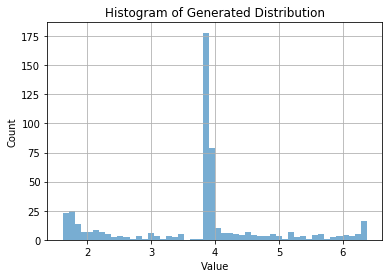

Seed: 123
[1.61412501, 3.470173, 3.87879944, 3.91737449, 6.37562752]
Run:  2
	 Epoch 0: D (0.7452121376991272 real_err, 0.6248567700386047 fake_err) G (0.7656559348106384 err); Real Dist ([4.025000101268292, 1.2373502300888044]),  Fake Dist ([0.02967732826247811, 0.03242824826532537]) 
	 Epoch 100: D (0.5585653781890869 real_err, 0.5729749798774719 fake_err) G (0.8286028504371643 err); Real Dist ([3.899461924672127, 1.2495992749599214]),  Fake Dist ([0.7392238429784774, 0.04834008077377778]) 
	 Epoch 200: D (0.4842550456523895 real_err, 0.4744419455528259 fake_err) G (0.9765562415122986 err); Real Dist ([4.063531409025193, 1.245357949500919]),  Fake Dist ([5.301458196640015, 0.032419081517924615]) 
	 Epoch 300: D (0.09526143968105316 real_err, 0.15163840353488922 fake_err) G (2.0735323429107666 err); Real Dist ([3.9665640243291853, 1.2701040108020476]),  Fake Dist ([4.211918259620666, 0.19530296095652147]) 
	 Epoch 400: D (0.5734265446662903 real_err, 0.5303922295570374 fake_err) G (0.

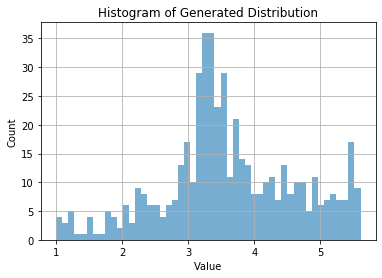

Seed: 123
[0.99703866, 3.1047678, 3.4866575, 4.31661081, 5.60870981]
Run:  3
	 Epoch 0: D (0.9064624309539795 real_err, 0.5441291928291321 fake_err) G (0.8662714958190918 err); Real Dist ([4.038293436169624, 1.2414996003962782]),  Fake Dist ([0.6345510179996491, 0.04064473050906124]) 
	 Epoch 100: D (0.6353440284729004 real_err, 0.6675142645835876 fake_err) G (0.7197331190109253 err); Real Dist ([3.92022041618824, 1.2520217119779018]),  Fake Dist ([0.7647347803115845, 0.019341730413185453]) 
	 Epoch 200: D (0.572625458240509 real_err, 0.5983138084411621 fake_err) G (0.8063210248947144 err); Real Dist ([3.999694592118263, 1.3751769974713546]),  Fake Dist ([2.4945209589004516, 0.03386593397809853]) 
	 Epoch 300: D (0.380525141954422 real_err, 0.38435763120651245 fake_err) G (1.1465975046157837 err); Real Dist ([4.001916147351265, 1.2584404933384263]),  Fake Dist ([5.29869649887085, 0.01194481577750935]) 
	 Epoch 400: D (0.12069988995790482 real_err, 0.2026364505290985 fake_err) G (1.7187

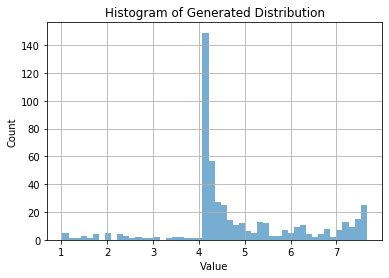

Seed: 123
[1.02428412, 4.15462017, 4.34925413, 5.64121008, 7.66316223]
Run:  4
	 Epoch 0: D (0.6780856847763062 real_err, 0.7104710936546326 fake_err) G (0.6723717451095581 err); Real Dist ([4.082723996996879, 1.2692890337508191]),  Fake Dist ([-0.031132488638162613, 0.004158356698984321]) 
	 Epoch 100: D (0.6726153492927551 real_err, 0.6384070515632629 fake_err) G (0.7530460357666016 err); Real Dist ([4.031995413541794, 1.2637504941387816]),  Fake Dist ([0.2506682037115097, 0.009281864647345123]) 
	 Epoch 200: D (0.5976290106773376 real_err, 0.5765562057495117 fake_err) G (0.8137569427490234 err); Real Dist ([3.936396045207977, 1.2288252573304639]),  Fake Dist ([3.2074032135009767, 0.01688188159909884]) 
	 Epoch 300: D (0.20280975103378296 real_err, 0.23138654232025146 fake_err) G (1.589045524597168 err); Real Dist ([3.9228731932640075, 1.2500167044887467]),  Fake Dist ([5.033980358123779, 0.022581311319433434]) 
	 Epoch 400: D (0.4922115206718445 real_err, 0.9316446185112 fake_err) G

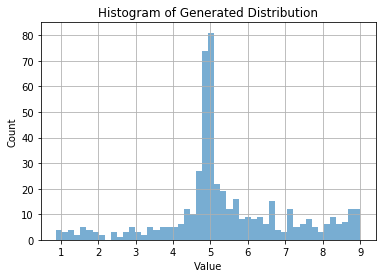

Seed: 123
[0.87779421, 4.78696132, 5.02011561, 6.30502248, 9.00600529]
Run:  5
	 Epoch 0: D (0.6483129858970642 real_err, 0.7326809167861938 fake_err) G (0.6554861664772034 err); Real Dist ([3.985267109632492, 1.2356081514985142]),  Fake Dist ([0.1064160122871399, 0.0044308066588804144]) 
	 Epoch 100: D (0.5973156094551086 real_err, 0.6408782601356506 fake_err) G (0.7467300295829773 err); Real Dist ([3.940298471301794, 1.168894337522311]),  Fake Dist ([0.4951529821753502, 0.009497751685415575]) 
	 Epoch 200: D (0.6090989112854004 real_err, 0.6230369806289673 fake_err) G (0.7681124806404114 err); Real Dist ([4.029748376309872, 1.2455262840699584]),  Fake Dist ([3.166158604621887, 0.004968300941405584]) 
	 Epoch 300: D (0.45132550597190857 real_err, 0.4532020092010498 fake_err) G (0.9838021993637085 err); Real Dist ([4.033858232200146, 1.2081762609327067]),  Fake Dist ([3.755373298168182, 0.2891606937890013]) 
	 Epoch 400: D (0.5306394696235657 real_err, 0.6108314990997314 fake_err) G (0

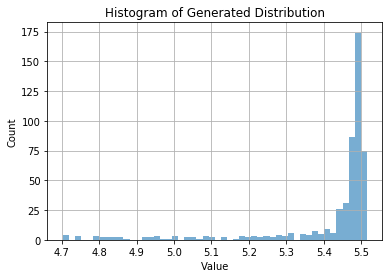

Seed: 123
[4.7026124, 5.44624567, 5.48223543, 5.49345112, 5.51488256]
Run:  6
	 Epoch 0: D (0.6050108671188354 real_err, 0.7844213843345642 fake_err) G (0.6106118559837341 err); Real Dist ([3.965825160300359, 1.2209692478065863]),  Fake Dist ([0.16617946147918702, 0.02081996951293466]) 
	 Epoch 100: D (0.62514728307724 real_err, 0.6342986226081848 fake_err) G (0.7558499574661255 err); Real Dist ([3.962600977540016, 1.2418446255345057]),  Fake Dist ([0.3199019473195076, 0.02871190070095908]) 
	 Epoch 200: D (0.619042694568634 real_err, 0.6242309212684631 fake_err) G (0.7281914353370667 err); Real Dist ([4.035449884727597, 1.2756499996161013]),  Fake Dist ([3.8170402870178224, 0.02176289926162847]) 
	 Epoch 300: D (0.5629280209541321 real_err, 0.6049602031707764 fake_err) G (0.6397861242294312 err); Real Dist ([3.978204193174839, 1.2235240078017642]),  Fake Dist ([2.1777678601741792, 0.7875706218092736]) 
	 Epoch 400: D (0.6471818685531616 real_err, 0.6086427569389343 fake_err) G (0.7875

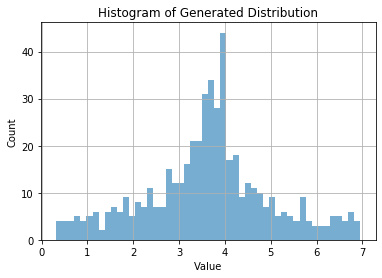

Seed: 123
[0.31438398, 2.87593341, 3.69075036, 4.28860903, 6.95740175]
Run:  7
	 Epoch 0: D (0.855401337146759 real_err, 0.5478029251098633 fake_err) G (0.8611540198326111 err); Real Dist ([4.020618654817342, 1.197300915693281]),  Fake Dist ([0.40145168417692184, 0.02835836170474912]) 
	 Epoch 100: D (0.6089818477630615 real_err, 0.6126682162284851 fake_err) G (0.7797020673751831 err); Real Dist ([4.001122509062291, 1.2525254161425885]),  Fake Dist ([0.8043276129961013, 0.035258847176032296]) 
	 Epoch 200: D (0.5634374022483826 real_err, 0.49946731328964233 fake_err) G (0.9264730215072632 err); Real Dist ([3.945064942598343, 1.226659435063232]),  Fake Dist ([4.97569371509552, 0.015788313024456845]) 
	 Epoch 300: D (0.11671634763479233 real_err, 0.12228800356388092 fake_err) G (2.1615331172943115 err); Real Dist ([3.9870156463980675, 1.2000377787312773]),  Fake Dist ([5.844067687034607, 0.05466347452396453]) 
	 Epoch 400: D (0.7208980321884155 real_err, 0.751124382019043 fake_err) G (0.

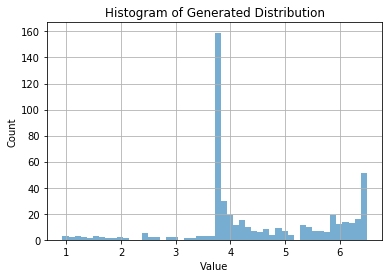

Seed: 123
[0.92733067, 3.73749673, 4.03320026, 5.82330298, 6.49301577]
Run:  8
	 Epoch 0: D (0.5832399129867554 real_err, 0.8052946329116821 fake_err) G (0.5933502912521362 err); Real Dist ([4.088795127928257, 1.2311767862213692]),  Fake Dist ([-0.8678778821229934, 0.004396302674601478]) 
	 Epoch 100: D (0.5689836740493774 real_err, 0.6412680745124817 fake_err) G (0.7466462254524231 err); Real Dist ([4.031177474215626, 1.2882102121491292]),  Fake Dist ([-0.5060554538965225, 0.0016786577574705364]) 
	 Epoch 200: D (0.5807572603225708 real_err, 0.5892087817192078 fake_err) G (0.8005080819129944 err); Real Dist ([4.084810042142868, 1.226548779315927]),  Fake Dist ([3.189446165084839, 0.006490252089455681]) 
	 Epoch 300: D (0.19840064644813538 real_err, 0.20707890391349792 fake_err) G (1.6280112266540527 err); Real Dist ([3.984356853887439, 1.2632370739129157]),  Fake Dist ([5.696772296905517, 0.00956374714153219]) 
	 Epoch 400: D (0.6159635782241821 real_err, 0.6252234578132629 fake_err) 

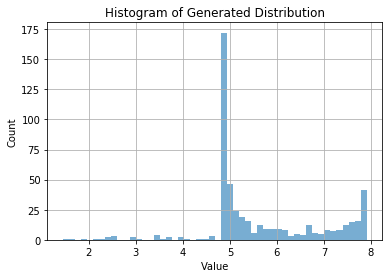

Seed: 123
[1.4404273, 4.86101079, 5.09028363, 6.67314172, 7.91402388]
Run:  9
	 Epoch 0: D (0.6007359027862549 real_err, 0.7967936396598816 fake_err) G (0.600295901298523 err); Real Dist ([4.000212944328785, 1.2655777905345313]),  Fake Dist ([-0.31485028126835823, 0.09544299328179819]) 
	 Epoch 100: D (0.6421005129814148 real_err, 0.6727753281593323 fake_err) G (0.7141115069389343 err); Real Dist ([4.00716042932868, 1.2315730044220052]),  Fake Dist ([-0.2077947917431593, 0.08834049865598136]) 
	 Epoch 200: D (0.5886031985282898 real_err, 0.6354088187217712 fake_err) G (0.7569323182106018 err); Real Dist ([3.9330717724561692, 1.2693471875305091]),  Fake Dist ([1.7453102102279663, 0.006128134452789648]) 
	 Epoch 300: D (0.46840521693229675 real_err, 0.37256374955177307 fake_err) G (1.0645332336425781 err); Real Dist ([4.089575894117355, 1.2440970199563905]),  Fake Dist ([5.727729568481445, 0.013653535591450374]) 
	 Epoch 400: D (0.8946681618690491 real_err, 0.7541717886924744 fake_err) G

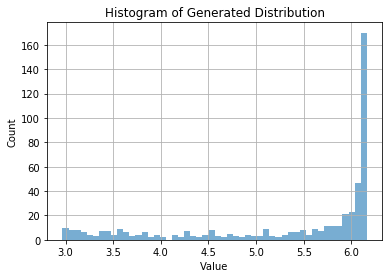

Seed: 123
[2.96761703, 4.59823823, 5.95017767, 6.13095522, 6.1617837]
450.59897089004517


In [2]:
for i in range(10):
    print("Run: ", i)
    ret_values = train()
    print("Seed: %d" % seed)
    # print("Seed: %d; epochs: %d" % (seed, epochs))
    print(fivenum(ret_values))
    
elapsed = time.time() - t
print(elapsed)    

seed  epochs samples fivenum                                                         elapsed
123  1350     10     [2.96761703, 4.59823823, 5.95017767, 6.13095522, 6.1617837]       450.6s  plot
123  1350     10     [1.25216794, 4.08316994, 4.11475229, 4.87367249, 7.09628868]     2387.1s  plot
123   500     10     [4.68381405, 6.96075773, 10.52783871, 10.84263134, 10.88271141]   222.5s  plot